# 2. Classify Manhattan with TensorFlow

In this codelab, we will use TensorFlow to train a neural network to predict whether a location is in Manhattan or not, by looking at its longitude and latitude.

<br/>
![](images/manhattan.png)
<br/>
<br/>

### Labs and Solutions

In this codelab there are several Labs (cells) where you need to write your code to solve the problems. If you need some hints, you may take a look at the [Solution](2.%20Classify%20Manhattan%20with%20TensorFlow%20_Solution_.ipynb) page to see the answers.

### Update TensorFlow to version 1.0 or above

To check the version of TensorFlow running in your Cloud Datalab, **select the cell below and run the code by clicking "Run" on the menu near the top of the page**.

In [ ]:
import tensorflow as tf
tf.__version__

This codelab requires TensorFlow 1.0 or above. If you see older versions such as 0.11.0rc0, please follow the instruction below to update your local Datalab.

- Stop your Datalab by pressing Ctrl+C on the console
- Run the following command on the console
```
> docker pull gcr.io/cloud-datalab/datalab:local
```
- Run the [`docker run`](https://cloud.google.com/datalab/docs/quickstarts/quickstart-local#install_the_datalab_docker_container_on_your_computer) command to restart local Datalab

---
## 2-1. Importing the training data from BigQuery

To prepare for the analysis, we will download a training data from [BigQuery](https://cloud.google.com/bigquery/), a fully managed scalable data warehouse service on Google Cloud. BigQuery provides many kinds of [public datasets](https://cloud.google.com/bigquery/public-data/) which makes it a useful datasource for learning data analytics with TensorFlow.

One of the public datasets is [NYPD Motor Vehicle Collisions Data](https://cloud.google.com/bigquery/public-data/nypd-mv-collisions) which collects all the car accidents happened in NYC from 2012 to the present. In this codelab, we will use it for getting 10,000 pairs of "borough" column and "latitude/longitude" columns.

Let's take a look at the data by executing a BigQuery SQL query. In Cloud Datalab, you can execute BigQuery commands by using the "%%sql" command (see [this doc](https://github.com/googledatalab/notebooks/tree/master/tutorials/BigQuery) to learn more about the BigQuery commands). **Select the cell below and run the query** by clicking "Run" on the menu.

In [ ]:
%%sql -d standard
SELECT
  timestamp,
  borough,
  latitude,
  longitude
FROM
  `bigquery-public-data.new_york.nypd_mv_collisions`
ORDER BY
  timestamp DESC
LIMIT
  15

### Preprocess the training data on BigQuery

In this codelab, we do not care about the car accidents. We just wanted to use the data for getting pairs of "latitude", "longitude" and "Is it Manhattan or not" values. So, we want to do the following preprocessing on this raw data:

- Add a column "is_mt" that returns 1 or 0 to indicate if the borough is Manhattan or not
- Remove rows without borough info
- Remove rows without longitude/latitude info
- Remove rows for Bronx (because it's too close to Manhattan and hard to classify with single layer neural network!)
- Randomly shuffule all the rows (for making the training data even)
- Select only the 10,000 rows

So, our SQL with the preprocessing will look like the following. **Select the cell below and run it**. Please note that this only defines the SQL module "nyc_collisions" that will be used later and **does not output anything**.

In [36]:
%%sql --module nyc_collisions
SELECT
  IF(borough = 'MANHATTAN', 1, 0) AS is_mt,
  latitude,
  longitude
FROM
  `bigquery-public-data.new_york.nypd_mv_collisions`
WHERE
  LENGTH(borough) > 0
  AND latitude IS NOT NULL AND latitude != 0.0
  AND longitude IS NOT NULL AND longitude != 0.0
  AND borough != 'BRONX'
ORDER BY
  RAND()
LIMIT
  10000

### Import the BigQuery SQL result as NumPy array

Then, we need to execute the SQL code defined above using BigQuery and import the data into Datalab. For this purpose, Datalab provides [BigQuery APIs](https://github.com/googledatalab/notebooks/blob/master/tutorials/BigQuery/BigQuery%20APIs.ipynb) that allows you to execute the define SQL and import the results as a [NumPy](http://www.numpy.org/) array named `nyc_cols`. **Run the cell below** and confirm it loaded 10,000 rows.

In [37]:
import datalab.bigquery as bq
nyc_cols = bq.Query(nyc_collisions).to_dataframe(dialect='standard').as_matrix()
print(nyc_cols)
print("\nLoaded " + str(len(nyc_cols)) + " rows.")

[[  1.         40.75076   -73.96843  ]
 [  0.         40.7529959 -73.9106765]
 [  0.         40.7119987 -73.7894136]
 ..., 
 [  0.         40.7236532 -73.9330838]
 [  0.         40.6917961 -73.9596848]
 [  0.         40.5889959 -73.8162865]]

Loaded 10000 rows.


Let's take a look at what's inside the result. **Run the cell below** and check the variable `is_mt` has an array of 1s and 0s representing each geolocation is in Manhattan or not, and the variable `latlng` has an array of pairs of latitude and longitude.

In [38]:
import numpy as np
is_mt = nyc_cols[:,0].astype(np.int32) # read the 0th column (is_mt) as int32
latlng = nyc_cols[:,1:3].astype(np.float32) # read the 1st and 2nd column (latitude and longitude) as float32
print("Is Manhattan: " + str(is_mt))
print("\nLat/Lng: \n\n" + str(latlng))

Is Manhattan: [1 0 0 ..., 0 0 0]

Lat/Lng: 

[[ 40.75075912 -73.96842957]
 [ 40.75299454 -73.91067505]
 [ 40.71199799 -73.78941345]
 ..., 
 [ 40.72365189 -73.93308258]
 [ 40.69179535 -73.95968628]
 [ 40.58899689 -73.81628418]]


---
### Lab: NumPy basics

(You can skip this lab if you know how to use NumPy)

You might notice that we just used NumPy for extracting the results. NumPy is the most popular Python library for numerical calculations. For machine learning with Python, many people use NumPy for wide variety of numerical operations, including the basic array operations such as reshaping, merging, splitting, filtering, slicing and indexing. Many of TensorFlow APIs are also influenced by NumPy and use similar concepts. If you want to learn machine learning and TensorFlow with Python, we recommend you also learn some of [the basics of NumPy](https://docs.scipy.org/doc/numpy-dev/user/quickstart.html) too.

In this lab, Let's try a few basic array operations with NumPy. **Run the cell below** and see what kind of numpy array will be created.

In [ ]:
# create an numpy array with numbers from 0 to 14
A = np.arange(15)
print(A)

Now, add the necessary new code in the following cells, and run them, to get the result described in the comments with NumPy. You should refer to the [NumPy Quickstart](https://docs.scipy.org/doc/numpy-dev/user/quickstart.html) to learn how to get the results required.

In [ ]:
# reshape the array A into an array with shape in 3 rows and 5 columns,
# set it to variable A, and print it.

# *** ADD YOUR CODE HERE ***

print(A)

# expected result:
# [[ 0  1  2  3  4]
#  [ 5  6  7  8  9]
#  [10 11 12 13 14]]

In [ ]:
# print() the shape, data type name, size (total number of elements) of the array A

# *** ADD YOUR CODE HERE ***

# expected result:
# (3, 5)
#  int64
# 15

In [ ]:
# multiply the array A by the number 2 and print the result

# *** ADD YOUR CODE HERE ***

# expected result:
# [[ 0  2  4  6  8]
#  [10 12 14 16 18]
#  [20 22 24 26 28]]

In [ ]:
# create a new array that has the same shape as the array A filled with zeros, and print it

# *** ADD YOUR CODE HERE ***

# expected result:
# [[ 0.  0.  0.  0.  0.]
#  [ 0.  0.  0.  0.  0.]
#  [ 0.  0.  0.  0.  0.]]

In [ ]:
# create a new array that has the elements in the right-most column of the array A

# *** ADD YOUR CODE HERE ***

# expected result:
# [ 4  9 14]

In [ ]:
# Collect elements in array B with an index "I % 2 == 0" and print it
B = np.arange(10)
I = np.arange(10)

# *** ADD YOUR CODE HERE ***

# expected result:
# [0 2 4 6 8]

---
## 2-2. Feature scaling and splitting data

Now we've got the training data. However, it's not ready for training a neural network model yet. If you use the raw data directly, you would fail on the training because the scales of each feature (latitude and longitude in this case) are quite different. 

In machine learning, it is very common to preprocess the raw data with [feature scaling](https://en.wikipedia.org/wiki/Feature_scaling) to normalize the feature data to have the same scale. That make it much easier for machine learning algorithms to compare those features and find relationships between them.

In this codelab, we will use [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) in [scikit-learn](http://scikit-learn.org/). Scikit-learn is another popular library for machine learning in Python that provides wide variety of training algorithms, preprocessing and validation tools. 

The StandardScaler scales the features so that their mean value will be 0 and standard deviation will be 1. This scaling is called **Standardization**. Let's **Run the cell below** and see how it scales the latitudes and longitudes and stores them into a variable `latlng_std`.

In [39]:
from sklearn.preprocessing import StandardScaler
latlng_std = StandardScaler().fit_transform(latlng)
print(latlng_std)

[[ 0.73830098 -0.41398409]
 [ 0.77360737  0.25095534]
 [ 0.12610282  1.64706469]
 ..., 
 [ 0.31016594 -0.0070271 ]
 [-0.1929801  -0.31332088]
 [-1.81659162  1.33769655]]


---
### Lab: check the standardized feature values

- Print mean and standard deviation values on both latitude and longitude of variable `latlng_std` by using NumPy and confirm the mean is almost 0 and standard deviation is 1.

In [ ]:
# *** ADD YOUR CODE HERE ***


---
### Plot the training data with Matplotlib

Now, all the preprocessing on the training data have been done. Let's see what the data looks like by using [Matplotlib](http://matplotlib.org/), the popular visualization library for Python. In this case we will use [scatter()](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter) method to plot dots with the pairs of latitude and longitude. **Run the cell below** and see the plot.

In [ ]:
import matplotlib.pyplot as plt
lat = latlng_std[:,0]
lng = latlng_std[:,1]
plt.scatter(lng[is_mt == 1], lat[is_mt == 1], c='b') # plot points in Manhattan in blue
plt.scatter(lng[is_mt == 0], lat[is_mt == 0], c='y') # plot points outside Manhattan in yellow
plt.show()

You can see that the geolocations in Manhattan are plotted as blue dots, and others are yellow dots. Also, latitudes and longitudes are scaled to have 0 as the center.

### Split the data into "Training Data" and "Test Data"

Before start training the neural network model, we need to separate out a part of the training data as test data. The test data will be used for checking accuracy of classifications by the model after training.  This is common practice in machine learning, so that the performance of your model can be accurately evaluated.

**Run the cell below** and split the data into 8,000 pairs of training data and 2,000 pairs of test data.

In [ ]:
# 8,000 pairs for training
latlng_train = latlng_std[0:8000]
is_mt_train = is_mt[0:8000]

# 2,000 pairs for test
latlng_test = latlng_std[8000:10000]
is_mt_test = is_mt[8000:10000]

print("Split finished.")

---
### Lab: Disscuss the preprocessing

Discuss the following topics with your buddy:

- What preprocessing steps we have done so far?
- Why is each proprocessing step required?
- What NumPy and Matplotlib functions have used to plot the map?
- Why do we need to split the data into training and testing sets?.

---
## 2-3. Train the Neural Network with TensorFlow High level API

<br/>
![](images/tflogo.png)
<br/>

Now, let's use [TensorFlow](https://www.tensorflow.org/).

TensorFlow is an open source library for machine learning. You can define your own neural network or deep learning model and run the training on your laptop, or use [many CPUs and GPUs in the cloud](https://cloud.google.com/ml/) for scalable and faster training and prediction.

TensorFlow provides two kind of APIs:

- [High level API](https://www.tensorflow.org/get_started/tflearn): provides easy-to-use [predefined machine learning models](https://www.tensorflow.org/api_guides/python/contrib.learn#estimators)
- [Low level API](https://www.tensorflow.org/get_started/get_started): provides customizable dataflow computation framework for machine learning

If you will use common neural network and machine learning models (such as fully-connected neural networks, convolutional neural networks, logistic regressions and k-means), the high level API is recommended. If you want to design your own neural network model with sophisticated or novel algorithms, or if you want to learn the underlying technology used for implementing the high level API, the low level API is the best option.

In this codelab, we will use the high level API first, and then look at the low level API to learn more about the underlying technology.

### Define a single layer neural network

**Run the cell below** to define a neural network.

In [40]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR) # supress warning messages

# define two feature columns consisting of real values
feature_columns = [tf.contrib.layers.real_valued_column("", dimension=2)]

# create a neural network
dnnc = tf.contrib.learn.DNNClassifier(
  feature_columns=feature_columns,
  hidden_units=[],
  n_classes=2)

dnnc

DNNClassifier(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._BinaryLogisticHead object at 0x7ff53c392290>, 'hidden_units': [], 'feature_columns': (_RealValuedColumn(column_name='', dimension=2, default_value=None, dtype=tf.float32, normalizer=None),), 'embedding_lr_multipliers': None, 'optimizer': None, 'dropout': None, 'gradient_clip_norm': None, 'activation_fn': <function relu at 0x7ff5561cea28>, 'input_layer_min_slice_size': None})

The code above does the following:

- Line 2 sets the log level to ERROR to supress warning messages
- Line 5 defined the "feature columns" (columns in the training data used for training the model) as two dimensional real values
- Line 8 defines a neural network by using [DNNClassifier](https://www.tensorflow.org/api_docs/python/tf/contrib/learn/DNNClassifier) class with the following parameters:
 - No hidden units (= fully connected single layer neural network)
 - Two classes for classification (Manhattan or not)
 
In a nutshell, this code defines a neural network like the following illustration, which is the same single neuron we tried with the Playground, where we put latitude and longitude as inputs to x1 and x2 respectively.

<br/>
![](images/singleneuron.png)
![](images/nnformula.png)
<br/>

Just like we saw on the Playground, the neuron can classify each datapoint into two groups by drawing **a single straight line**. While training this neuron with the training data, the neuron tries to move the weight and bias values to find what's the best angle and position for the line to classify Manhattan correctly.

<br/>
![](https://cloud.google.com/blog/big-data/2016/07/images/146798944178238/neuralnetworks-22.png)
<br/>

So here, we're training a neural network (consisting of a single neuron) to classify whether a geolocation is in Manhattan or not by drawing a single straight line on the map.

### Check the accuracy of the neural network

Before starting to train the neural network, let's define two methods for checking the accuracy of the neural network. **Run the cell below**.

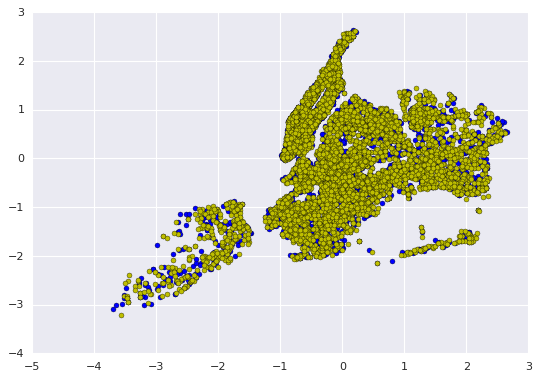

Accuracy: 28.65%


In [41]:
# plot a predicted map of Manhattan
def plot_predicted_map():
  is_mt_pred = dnnc.predict(latlng_std, as_iterable=False) # an array of prediction results
  plt.scatter(lng[is_mt_pred == 1], lat[is_mt_pred == 1], c='b')
  plt.scatter(lng[is_mt_pred == 0], lat[is_mt_pred == 0], c='y')
  plt.show()

# print the accuracy of the neural network
def print_accuracy():
  accuracy = dnnc.evaluate(x=latlng_test, y=is_mt_test)["accuracy"]
  print('Accuracy: {:.2%}'.format(accuracy))
  
# train the model for just 1 step and print the accuracy
dnnc.fit(x=latlng_train, y=is_mt_train, steps=1)
plot_predicted_map()
print_accuracy()

In the first method `plot_predicted_map()` at line 3, we call the  [predict()](https://www.tensorflow.org/api_docs/python/tf/contrib/learn/DNNClassifier#predict) method of `DNNClassifier` class to get an array of prediction results (10,000 rows) like `[1 0 0 1 ... 0 0 1 0]` where `1` means that the neural network believes the geolocation is in Manhattan, and `0` means it's not. By using this array as an indexer for selecting `lat` and `lng` pairs in each class, the method plots geolocations predicted as Manhattan in blue dots and others in yellow dots.

In the second method `print_accuracy()` at line 9, we call the [evaluate()](https://www.tensorflow.org/api_docs/python/tf/contrib/learn/Evaluable#evaluate) method of `DNNClassifier` class to calculate the accuracy of the prediction using the test data `latlng_test` and `is_mt_test` and print it.

After defining these two methods, we call the [fit()](https://www.tensorflow.org/api_docs/python/tf/contrib/learn/Trainable#fit) method of `DNNClassifier` class at line 14 to train the model for just **one step**. A step in the `fit()` method moves the weights and bias in the neural network only a little in the direction that reduces the network error. However, it usually it takes thousands of steps for neural networks to find the best weights and bias. So, what you are effectively seeing is that the neural network in the initial state (= before the training) acheives a very low accuracy and cannot classify the Manhattan locations properly. 

### Train the neural network

Finally, let's actually train the neural network! This time, we will train the network by calling `fit()` method for 500 steps with the training data `latlng_train` and `is_mt_train`. Every 100 steps, we will call `plot_predicted_map()` and `print_accuracy()` to show the current accuracy of the network. **Run the cell below** and wait for a while until the message "Finished" is printed. You will see the network continually tries to **move the weights and bias in small steps** to minimize the error and find the best position of the line for classifying geolocations in Manhattan. The final accuracy should be as high as 97%.

In [ ]:
steps = 100
for i in range (1, 6):
  dnnc.fit(x=latlng_train, y=is_mt_train, steps=steps)
  plot_predicted_map()
  print('Steps: ' + str(i * steps))
  print_accuracy()
  
print('\nTraining Finished.')

---
### Lab: Try training the neural network a couple of times

- Go back to the section "Define a single layer neural network" and run the following cells again to train the network from scratch
- Repeat the training a couple of times and confirm that the network's max accuracy is around 97%
- Discuss with your buddy the key reason that the single layer network can't achieve accuracy higher than 97%. The single layer neural network is also known as **Perceptron**. You may refer to the [Wikipedia page for Perceptron](https://en.wikipedia.org/wiki/Perceptron) to learn more about its characteristics and limitations.

---
## 2-4. Train a Deep Neural Network with TensorFlow

You just saw that the network can only draw **a straight line** on the map and classify whether a location is in Manhattan or not. This is so-called **Linear Classification**. That is the limitation of the single layer neural network and you can only achieve around 97% accuracy because the straight line (linear classification) can't split the geolocation points between Manhattan and Brooklyn with the necessary curved boundary.

We must go deeper. Let's define a deep neural network (DNN). **Run the cell below** to define a new `DNNClassifier`.

In [ ]:
dnnc = tf.contrib.learn.DNNClassifier(
  feature_columns=feature_columns,
  hidden_units=[20, 20, 20, 20],
  n_classes=2)
dnnc

### The hidden layers give the power

The only difference from the last `DNNClassifier` definition is the `hidden_units` parameter which defines **4 hidden layers with 20 neurons each**. As the network has total of 5 layers, we're now working with a deep neural network ("deep" means you have layers more than 2). 

Let's see how the deep neural network works. **Run the cell below** and wait for a couple of minutes until it finishes training.

In [ ]:
steps = 30
for i in range (1, 6):
  dnnc.fit(x=latlng_train, y=is_mt_train, steps=steps)
  plot_predicted_map()
  print 'Steps: ' + str(i * steps)
  print_accuracy()
  
print('\nTraining Finished.')

You just saw that a DNN can classify locations within Manhattan at around 99.9% accuracy with a curved boundary that fits between Manhattan and Brooklyn. In the next section, we will learn how a DNN is able to recognize and extract the complex patterns in the training dataset by using the power of **hidden layers**.

---
### Lab: Train the network with different configurations

- Reduce the number of hidden layers to 3, 2 and 1 and retry training the network. See how it affects the accuracy
- Reduce the number of nodes in all hidden layers to 10 and retry training the network. See how it affects the accuracy
- Discuss with your buddy the reasons why the deep neural network achieves much higher accuracy than the single layer version

---
# What We Learned

In this section, we have learned the following concepts.

- With Cloud Datalab, you can execute **BigQuery SQLs** and import the result, so that we can then easily **preprocess** the training data
- In machine learning, preprocessing steps such as **feature scaling** with **standardization** and **splitting into training data and test data** are important procedures to apply before starting the training
- In machine learning with Python, you can use popular tools such as **NumPy**, **scikit-learn** and **Matplotlib** for those preprocessing and visualization
- **TensorFlow** provides both a **High level API** and a **Low level API**. Using the former allows you to implement common machine learning and neural network models quickly
- The **DNNClassifier** High-level API let you easily define, train and evaluate a neural network
- A single layer neural network is a **Linear Classifier**, which means that it has limitations on recognizing complex patterns in training data
- By using a **Deep Neural Network**, you can capture much more complex patterns from the training datawith its **hidden layers**, and then classify new inputs using the same model

# What's Next?

To learn more about deep neural networks, please proceed with [3. Why deep neural network can get smarter?](3.%20Why%20deep%20neural%20network%20can%20get%20smarter%3F.ipynb).